# Python機械学習 勉強会 第四回「教師あり学習3」

参考文献：  
Pythonではじめる機械学習　2章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

<br>

---

## はじめに

今回は以下の内容を取り組む

* 教師あり機械学習アルゴリズム
    * 決定木のアンサンブル法
    * カーネル法を用いたサポートベクタマシン

<br>

---

## 2.3 教師あり機械学習アルゴリズム
### 2.3.6 決定木のアンサンブル法

アンサンブル法とは、複数の機械学習モデルを組み合わせて、  
より強力なモデルを構築する手法。

代表的な手法として、以下2つを説明する。
* ランダムフォレスト
* 勾配ブースティング決定木

<br>

#### 2.3.6.1 ランダムフォレスト

ランダムフォレストを簡潔に表現すると、  
**少しだけ異なる決定木をたくさん集めて平均するモデル**、と言える。

個々の決定木は過学習していても、多数の平均をとることで、  
予測性能を維持したまま過学習を解決している
* 厳密な数学で証明できるが、ここでは詳細は述べない

ランダムフォレストは、決定木を多数生成するが、  
その際に少しだけ異なるように構築仮定で乱数を用いている。
* そのため**ランダム**フォレストと呼ぶ

<br>

乱数を導入する方法として、以下2つが挙げられる。
* データポイントを選択
* 分岐テストに用いる特徴を選択

<br>

ランダムフォレストが実現したいのは、少しだけ異なる多数の決定木を集めること。  
そのために、以下のような方法でモデルを構築する。

1. 構築する決定木の数を決める

1. データから**ブーストラップサンプリング(boostrap sample)**を行う  
データセットから、重複ありで同じ数だけを抽出する方法。  
これによって、元のデータセットと同じサイズだが、データの一部(約1/3)が欠け、  
また別の一部が重複しているデータが、複数(決定木の数だけ)作られる

1. 各決定木の学習の際に、使う特徴量の数もランダムに制限する

<br>

これらの方法によって、少しずつ異なるデータセット×異なる特徴量サブセット  
の組み合わせで多数の決定木が作られる。

実際に予測を行う際は、まず全ての決定木に対して予測を行い、  
結果の平均値を最終的な予測結果として出力する。

例として、two_moonsデータセットに適用してみる。

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

# n_estimators : 決定木の数
# randome_state : 乱数シード
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [3]:
type(forest)

sklearn.ensemble.forest.RandomForestClassifier

In [4]:
# 各決定木は、estimators_属性に格納されている
forest.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1872583848, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=794921487, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_wei

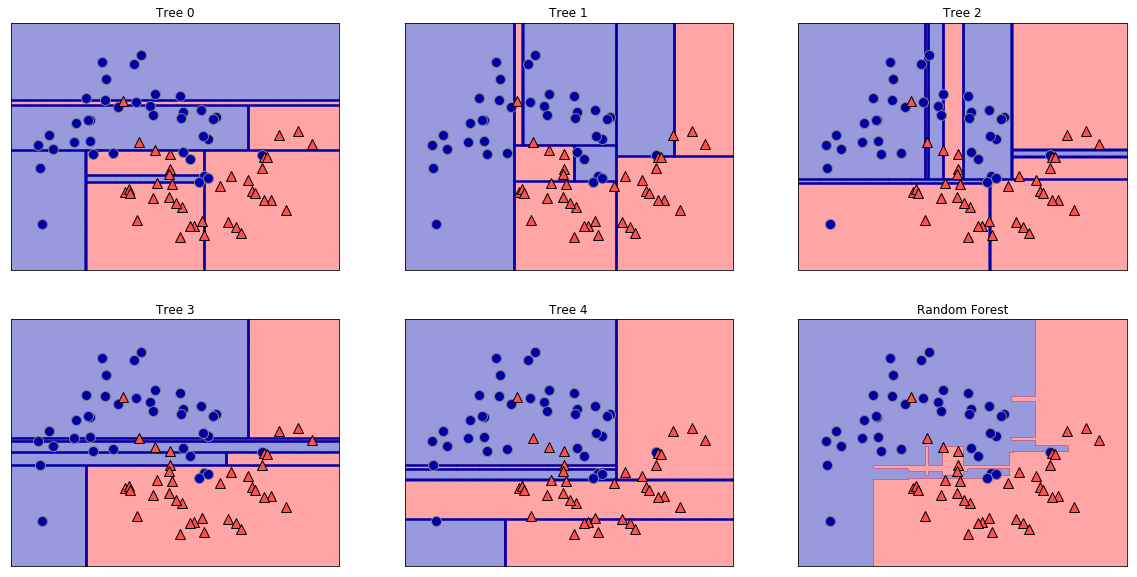

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

個々の決定木(Tree　0～4)は、明らかにそれぞれ異なっている。  
そして、ランダムフォレストはどの決定木よりも過学習の程度が低く、  
見た感じの直感に近い決定境界が作られている。

<br>

もう一つの例として、cancerデータセットに対して、100個の決定木を用いたランダムフォレストを試す。

In [6]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set\t: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set	: 1.000
Accuracy on test set		: 0.972


<br>

このランダムフォレストは、まったくパラメータを調整していないが、  
訓練セットに対する性能は線形モデルや決定木単体よりも高い。  

max_featuresパラメータや、個々の決定木に対して事前枝刈りを行うことで、  
さらにチューニングできるが、多くの場合はデフォルトのパラメータで十分機能する。

<br>

ランダムフォレストでも特徴量の重要度を確認できる。  
これは、個々の決定木の重要度を平均したものであり、個々の決定木のそれよりも信頼できる。

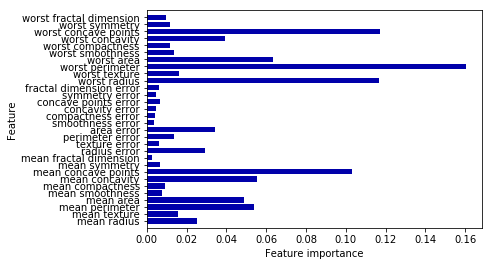

In [7]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    
    # 棒グラフ
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    
    # y軸の目盛設定
    plt.yticks(np.arange(n_features), cancer.feature_names)
    
    # 軸のタイトル
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    # y軸範囲の設定(見やすくするため)
    plt.ylim(-1, n_features)


plot_feature_importances_cancer(forest)

ランダムフォレストでは個々の決定木よりも、多くの特徴量に対して重要度を付与している。  
これは、乱数性によって広い視野で見た全体像をとらえているから。

<br>

**長所、短所、パラメータ**

ランダムフォレストは、本質的に決定木の長所を残したまま欠点の一部を補っており、  
非常に強力のため幅広く使われている。
また、多くの場合はパラメータチューニングせずに使える。

非常に大きなデータセットに対しても機能するし、
計算コストは(決定木より)大きいが、複数のCPUコアを使って並列化することで対応できる。
* n_jobsパラメータ

<br>

欠点として挙げるならば、決定木ではモデルの解釈が容易だったのに対し、  
ランダムフォレストでは何十～何百の決定木を解釈するのは不可能となる。  

また、非常に高次元で疎なデータではうまく機能しない傾向があるため、  
その場合は別のアルゴリズムを検討したい。

<br>

パラメータとして、以下の事前枝刈りパラメータが挙げられる。
* n_estimators : 決定木の数
* max_features : 個々の決定木で用いる特徴量の数
* max_depth    : 木の深さ

**n_estimators**  
大きければ大きいほど性能は高い。  
ただし、メモリの量も訓練時間も長くなるので、それらが許容できる範囲で最大の値にする

<br>

#### 2.3.6.2 勾配ブースティング回帰木(勾配ブースティングマシン)

勾配ブースティングは、1つ前の決定木の誤りを、次の決定木が修正するようにして、  
決定木を順番に作っていく。

* デフォルトでは乱数性はなく、強力な事前枝刈りが行われる。

* 深さ1～5位の非常に浅い決定木(**弱学習機(weak learner)と呼ぶ**)を用いて、  
それらを多数組み合わせることで、性能を向上させる。

* 名前に回帰とあるが、回帰にもクラス分類にも利用できる。

<br>

勾配ブースティングは機械学習のコンペでもよく優勝しており、  
産業界でも幅広く使われている強力な手法。

パラメータの設定がシビアだが、適切に設定できればランダムフォレストよりも性能が良い。

<br>
ここで、cancerデータセットに対して適用してみる。

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set\t: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set	: 1.000
Accuracy on test set		: 0.958


<br>

デフォルトパラメータでは、訓練精度が100%でテスト精度が低いので、  
おそらく過学習している。

ここで、木の深さを制限して協力な事前枝刈りを実施してみる。

In [9]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set\t: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set	: 0.991
Accuracy on test set		: 0.972


狙い通り、訓練精度は下がったが、テスト精度が向上している。

<br>

過学習を避ける別の手段として、**学習率(learning rate)**を下げる方法がある。
* 学習率：個々の決定木が、それまでの決定木の過ちをどれくらい補正するかの指標  
　　　　値が大きいと、強く補正しようとしてモデルが複雑になる＝過学習しやすい

In [10]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set\t: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set	: 0.988
Accuracy on test set		: 0.965


狙い通りテスト精度が向上したが、  
この場合では、max_depthで制御した方が、汎化性能が高い結果になった。

<br>

他の決定木ベースの方法と同様に、特徴の重要度を確認できる。

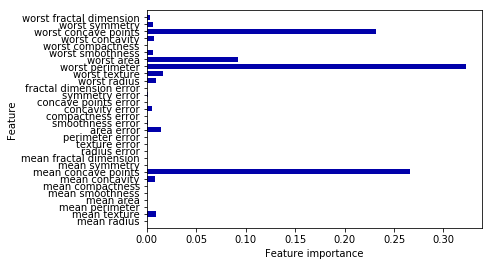

In [11]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

<br>

### TIPS

勾配ブースティングとランダムフォレストは同じようなデータを得意とする。  

まずはランダムフォレストで試してみるといい。  

ランダムフォレストでは予測時間がかかりすぎたり、  
ほんの少しでも性能を向上したい場合に勾配ブースティングを試すといい

<br>

### TIPS

勾配ブースティングの実装としては、大きく以下3つが挙げられる。
* scikit-learn
* xgboost
* light-gbm
* catboost

一般的には、scikit-learnの実装よりxgboost、xgboostよりはlight-gbmの方が、  
light-gbmよりはcatboostの方が高速で処理できる。

<br>

**長所、短所、パラメータ**

勾配ブースティング回帰木は、教師あり学習の中で最も強力で、広く使われている。  

他の決定木ベースのアルゴリズムと同様に、特徴量のスケール変換が不要で、  
2値特徴量と連続値特徴量が混在していてもうまく機能する。

<br>

欠点としては、訓練にかかる時間が長いことと、  
パラメータのチューニングに細心の注意がひつようであること。

<br>

主なパラメータは以下3つ。
* n_estimators : 決定木の数
* learning_rate : 学習率
* max_depth     : 木の深さ

ランダムフォレストではn_estimatorsは大きいほど性能が高かったが、  
勾配ブースティングでは過学習をまねきやすい。

一般的には、学習時間とメモリ量でn_estimatorsを決め、  
learning_rateを探索することで汎化性能を向上させる方法がとられる。

また、事前枝刈りとしてmax_depthを指定する際、  
通常では非常に小さく設定することが多く、深さが5以上になることはない。

<br>

### ！坪井注記！

この勉強会を実施している2019年10月時点では、  
データ分析コンペ(KaggleやSIGNATE)などでは、**勾配ブースティングマシンが主流**となっている。  

その中でも***light-gbm***は、データのスケール変換や  
欠損値処理などの前処理しなくても手軽に試せるので、特によく使われている。

* 画像コンペやNLPなどでは(ディープ)ニューラルネットワークも主流
* 線形モデル(RidgeやLasso、SVM)などは、主流ではない
* ただし、線形モデルもモデルアンサンブルなどには用いられる

ここではあまり説明してこなかったが、直近で機械学習(≠ディープラーニング)を試すならば、  
勾配ブースティングマシンを試すべき。

<br>

---

### 2-5. カーネル法を用いたサポートベクタマシン

線形サポートベクタマシンについては、第二回勉強会について軽く触れた。  
ここでは、カーネル法を用いたサポートベクタマシン(SVM)について説明する。

ただし、カーネル法を用いたサポートベクタマシンの数学的背景はかなり難しく、  
この勉強会の範囲を超えるので、詳細は省く。

<br>

#### 2-5-1. 線形モデルと非線形特徴量

第三回の勉強会で下の図を用いて説明したが、低次元における線形モデルは制限が強い。  
直線や超平面が柔軟性を制限している。

### TIPS


* 超平面：2次元の平面をそれ以外の次元に一般化したもの  
例えば、3次元においては次のように定義できる
    * 平面は自由度が2なので、2次元超平面
    * 直線は自由度が1なので、1次元超平面
    * 点は、自由度が0なので、0次元超平面
    
超平面とは、座標の次元を落としていったときにできる点の集合のこと。  
難しければ、2次元の「平面」のイメージで、多次元空間を分割する平面と思えばいい。

C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


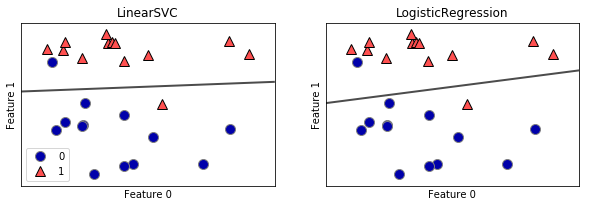

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

X, y = mglearn.datasets.make_forge()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    mglearn.plots.plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

<br>

線形モデルを柔軟にする方法の1つが、特徴量を追加すること。  
例えば、入力特徴量の交互作用(積)や多項式項を加えるなど。

合成データセット例に確認する。

Text(0, 0.5, 'Feature 1')

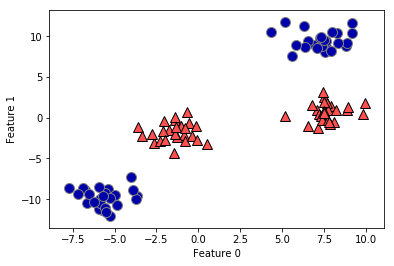

In [13]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

単純な線形モデルでは直線で分割することしかできないので、  
このようなデータセットにはうまく機能しない。

C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feature 1')

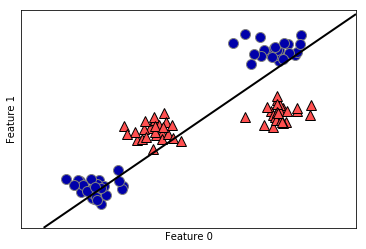

In [14]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

そこで、**特徴量**を拡張することで、単純な二次元の直線ではなく、  
n次元の超平面で分割することが可能となる。

Text(0.5, 0, 'feature1 ** 2')

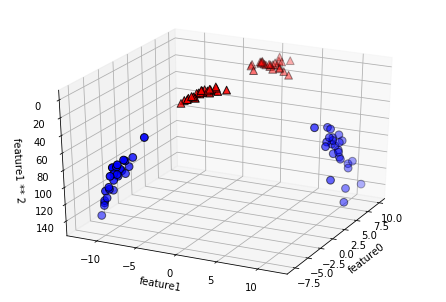

In [15]:
# 2番目の特徴量の二乗を追加
# Xデータに対して、Xの2番目の特徴量を二乗したデータを、水平方向に結合する
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d

figure = plt.figure()

# 3Dで可視化
ax = Axes3D(figure, elev=-152, azim=-26)

# y == 0の点をプロットしてから y == 1の点をプロット
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

この新しい特徴量空間では、2つのクラスを3次元空間内の平面を用いて分離することが可能となっている。

C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1 ** 2')

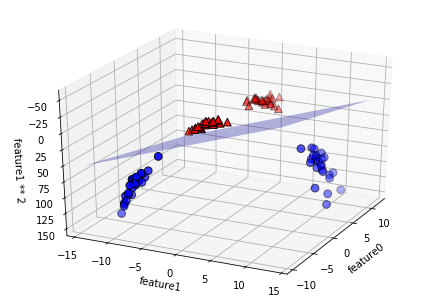

In [16]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 線形決定境界(Decision Boundary)を表示
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

もとの特徴量空間で見ると、線形SVMモデルは線形ではなくなっている。  
直線ではなく楕円に近い。

Text(0, 0.5, 'Feature 1')

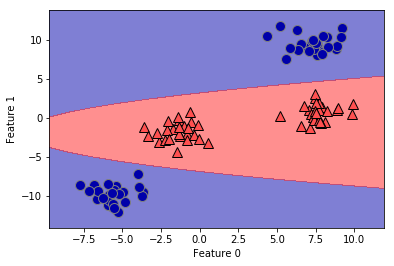

In [17]:

ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

<br>

#### 2-5-2. カーネルトリック

ここで分かったのは、非線形の特徴量をデータに加えることで、線形モデルが強力になること。  
ただし、実際にはどの特徴量を加えたら良いのかわからない。
* 単純にすべての特徴量の積を加えるなどやると計算コストが大きすぎる

<br>

そこで**カーネルトリック法(kernel trick)**と呼ばれる、  
高次元空間でのクラス分類器を学習させる数学的トリックがある。

これは、拡張された特徴量表現上でのデータポイント間の距離を、  
実際にデータポイントの拡張を計算せずに、直接計算する方法。

<br>

一般的な高次元空間へのマップ方法として、以下2つが挙げられる。  
1. 多項式カーネル(polynomial kernek):  
もとの特徴量の特定の次数までの全ての多項式(feature**2、 feature**5、その積、などなど)を計算する

1. ガウシアンカーネル(放射基底関数(radial basis function: RBF)とも呼ばれる):  
全ての次数の全ての多項式を考えるが、次数が高くなるにつれてその特徴量の重要性を小さくしている。

次にRBFを用いたSVMによる決定の様子を確認する。

<br>

#### 2-5-3. SVMを理解する

SVMは訓練の過程で、各データポイントが決定境界を決めるために、どれくらい重要か学習する。  
多くの場合で、境界の近くに位置する一部の訓練データポイントだけで、決定境界が決められる。

これらのデータポイントを**サポートベクトル**と呼び、サポートベクタマシンの由来となっている。

新しいデータポイントに対する予測の際は、サポートベクトルとの距離が測定され、  
この距離と訓練課程で学習された各サポートベクトルの重要性(SVCの***dual_coef_***属性)によって、クラスが決まる。

<br>

データポイント間の距離は次の式で定義される。

$$
k_{rbf}(x_1, x_2)=exp(-γ||x_1 - x_2||^2)
$$

x1, x2：データポイント  
||$X_1 - x_2$||：ユークリッド距離  
γ：ガウシアンカーネルの幅を制御するパラメータ

<br>

実際にRBFカーネル法を用いたSVMによる決定境界を確認する。  
ここでは、forgeデータセットに対してSVMを適用する。

Text(0, 0.5, 'Feature 1')

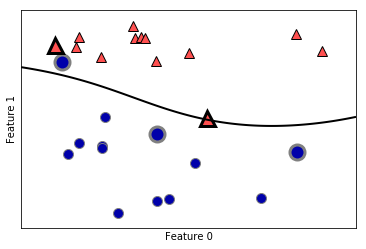

In [18]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)

mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# サポートベクトルをプロット
sv = svm.support_vectors_

# サポートベクトルのクラスラベルは dual_coef_ の正負によって与えられる
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

linearSVCと比較し、決定境界がなめらかで非線形ではないことが分かる。

<br>

#### 2-5-4. SVMパラメータの調整

RBF-SVMの代表的なパラメータとして以下2つが存在する。
* gamma : ガウン試案カーネルの幅。点が近いということを意味するスケールを決定
* C : 正則化項

具体的にこれらのパラメータを変えて確認する。

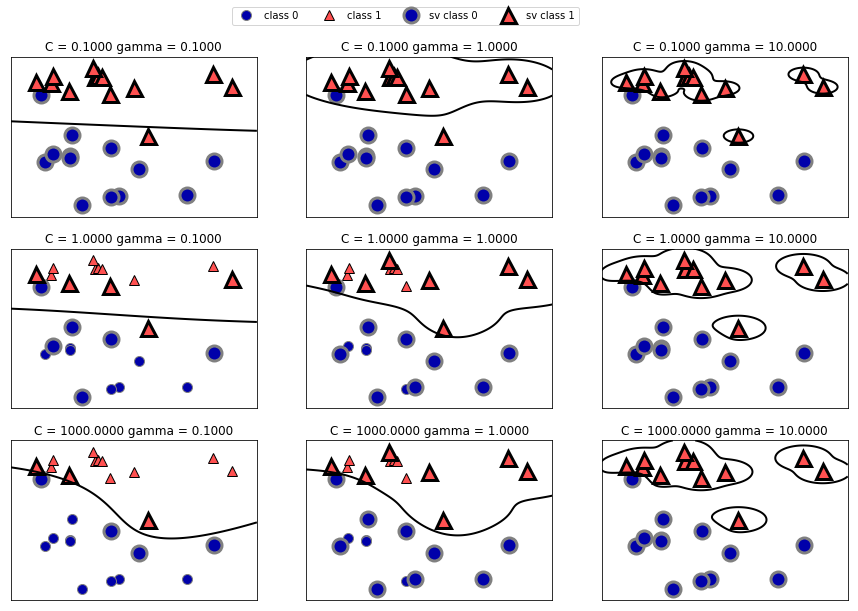

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

左から右に、gammaが大きくなっている。  
また、上から下に、Cが大きくなっている。

<br>

gammmaが小さいとガウシアンカーネルの直径が大きくなり、多くの点を近いと判断するようになる。  
つまり、gammmaが小さいと、決定境界はなめらかになり、モデルの複雑さは小さい。

Cが小さいと正則化項が強くなり、個々のデータポイントの与える影響は限定される。  
つまり、Cが小さいとモデルの複雑さは小さい。

RBFカーネルを用いたSVMを、cancerデータセットに適用してみる。

In [20]:
from sklearn.datasets import load_breast_cancer

# cancerデータセットの読み込み
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

print("Accuracy on training set\t: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set\t\t: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set	: 1.00
Accuracy on test set		: 0.63


この結果では明らかに過学習していることが分かる。  

<br>

SVMの欠点に、パラメータの設定と、各データのスケールの影響を強く受ける点がある。  
つまり、全ての特徴量の変位が同じスケールである必要があり、データの前処理が重要となる。

参考までに、今回用いたデータの最小値と最大値を、対数プロットで確認する。

Text(0, 0.5, 'Feature magnitude')

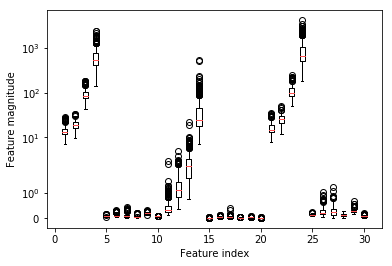

In [21]:
plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

cancerデータセットの特徴量は、桁違いのサイズであることがわかる。

次に、この問題に対応するための方法を学ぶ。

<br>

#### 2-5-5. SVMのためのデータの前処理

各特徴量間のスケールを調整する方法の1つに、  
「すべての特徴量間が0から1の間になる」ようにスケール変換することが挙げられる。

その1つとして、scikit-learnには***MinMaxScaler***クラスが定義されているが、  
ここでは理解のために手動でやってみる。

In [22]:
# 訓練セットの特徴量ごとに、最小値を計算する
min_on_training = X_train.min(axis=0)

# 訓練セットの特徴量ごとに、レンジ(最大値 - 最小値)を計算する。
range_on_training = (X_train - min_on_training).max(axis=0)

# 最小値を引いてレンジで割る
# 個々の特徴量は、min=0, max=1となる
X_train_scaled = (X_train - min_on_training) / range_on_training

print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


<br>

次に、テストセットに対しても、まったく同じ変換を行う。  

ここで重要なのは、訓練セットの最小値とレンジを用いてテストセットに適用すること。

In [23]:
X_test_scaled = (X_test - min_on_training) / range_on_training

In [24]:
svc = SVC(gamma='auto')
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set\t: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set	: 0.948
Accuracy on test set		: 0.951


データのスケールを調整したところ、精度が改善したことが分かる。

ただし、訓練セットもテストセットもだいたい同じで、かつ100%から遠いので、  
学習不足だと判断できる。

ここで、Cやgammmaパラメータを調整して、モデルをより複雑にする。

In [25]:
svc = SVC(C=1000, gamma='auto')
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set\t: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set\t\t: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set	: 0.988
Accuracy on test set		: 0.972


Cパラメータを調整すると、モデルは大きく改良された。

<br>

#### 2-5-5. 利点、欠点、パラメータ

カーネル法を用いたSVMは、広く使われている強力なモデルである。  

低次元のデータでも高次元のデータでもうまく機能するが、データのサンプル数が多いとうまく機能しない。
* データが100,000サンプルくらいになると、実行速度やメモリ使用量の面で厳しくなる

<br>

そのほかの欠点としては、データの前処理とパラメータ調整がシビアであること。

そのため、近年では実用上のアプリケーションとしては、  
勾配ブースティングなどの(前処理がほぼ不要な)決定木ベースのモデルの方が出番が多い。

全ての特徴量が似た(同じスケールの)データセットについては、SVMを試してみる価値がある。

<br>

カーネル法を用いたSVMには、重要な次のパラメータがある。
* C：正則化項
* カーネルの選択：scikit-learnにはRBF以外のカーネルも用意されている
* カーネル固有のパラメータ：RBFの場合はgammmaだけ

Cとgammmaは、両方モデルの複雑さを制御するパラメータであり、  
小さいとモデルが単純に、大きいとモデルが複雑になる。

2つのパラメータは強く相関するので、同時に調整する必要がある。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。